# Lab 2

### Lab Date: Wednesday, February 5

### Due: Wednesday, February 13

## Instructions

Work with your lab group to complete the following notebook. It will be reviewed by your peers in lab next week (Wednesday, February 13th). 

This lab builds directly on your first lab. The idea is to use the pipeline you developed last week to solve two Bayesian decision theory problems. Both are optimal resource allocations problems. 

If you are new to working in python, or in a Jupyter notebook, please ask your lab members for help. If you notice a lab member struggling, and have experience, please offer your help.

Please see this [Ed post](https://edstem.org/us/courses/74615/discussion/6107459) for corrections, questions, and discussion. If you would rather work with your own copy of the files, I have uploaded a zip folder there with the lab materials. You may use the same procedure you used last week to work with that folder. 

Corrections to the lab will be pushed directly to this notebook. We will only push corrections to the text, which is set to read only to prevent merge conflicts. In the event of a merge conflict, save your notebook under a different name, and click the link that launches the lab from the schedule on the [stat238 homepage](https://stat238.berkeley.edu/spring-2025/) again. Then, check for discrepancies. If you can't find them, or resolve the conflict, contact us.

In [1]:
# load whatever packages you prefer here. I've added a reference list
import numpy as np
import pandas as pd
import scipy as scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# import pymc as pm
# import bambi as bmb
# import arviz as az
# import statsmodels.api as sm

## The Setting

This week's lab will use the ``Kidney Cancer" data set from BDA (Gelman, Third Edition). The data set contains death counts due to kidney cancer in the United States. The counts are subdivided at a state and county level. The data set includes the county populations, and death counts over two 5 year periods (1980 - 1984, 1985 - 1989). 

Focus on the following columns in the kidney cancer dataset:
* `state`: the US state
* `Location`: the county and state as a string
* `fips`, which provides the [FIPS code]() for each county: this is a standard identifier that can often be used to join datasets with county-level information.
* `dc` and `dc.2`: the number of kidney cancer deaths between 1980-1984 and 1985-1989, respectively
* `pop` and `pop.2`: the population between 1980-1984 and 1985-1989, respectively


In [2]:
kc_full = pd.read_csv('kidney_cancer_1980.csv', skiprows=4)
# There are many other interesting columns, but we'll focus on these:
kc = kc_full.loc[:, ['state', 'Location', 'dc', 'dc.2', 'pop', 'pop.2']]
kc.head()

,state,Location,dc,dc.2,pop,pop.2
0,ALABAMA,"Autauga County, Alabama",2,1,61921,64915
1,ALABAMA,"Baldwin County, Alabama",7,15,170945,195253
2,ALABAMA,"Barbour County, Alabama",0,1,33316,33987
3,ALABAMA,"Bibb County, Alabama",0,1,30152,31175
4,ALABAMA,"Blount County, Alabama",3,5,88342,91547


Take a moment with your group to explore this data set. You should notice that, outside of the specific context, it takes the same form as the synthetic data set you studied last lab. The synthetic data set consisted of a collection of the form $\{n_j,S_j\}_{j=1}^{100}$ where each $n_j$ was a number of draws of a Bernoulli random variable and $S_j$ was the number of succesful draws.

Now, we have two datasets of this form. For each 5 year span you have a collection of the form $\{(n_j(t),D_j(t))\}_{j=1}^{2997}$. Here $t$ indexes a timespan (either 1980 - 1984 or 1985 - 1989).

In [3]:
# use this cell to perform whatever data exploration you want. 
# I suggest querying for the quantiles of the population and death count columns.
# In particular, the min and max are important. 
# Notice also that, while the population sizes are large, the observed rate of deaths per individual are small.

In [4]:
print(np.quantile(kc['pop'], .25))
print(np.quantile(kc['pop'], .5))
print(np.quantile(kc['pop'], .75))

print(np.quantile(kc['dc'], .25))
print(np.quantile(kc['dc'], .5))
print(np.quantile(kc['dc'], .75))

22382.5
47628.0
114626.25
1.0
2.0
6.0


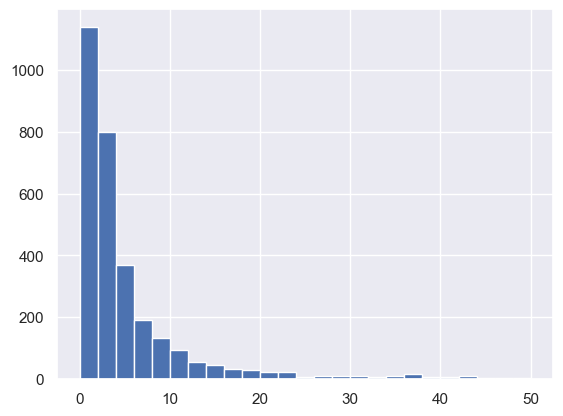

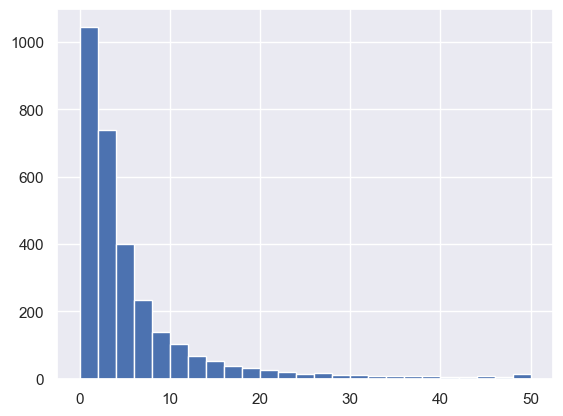

In [5]:
plt.hist(kc['dc'], bins=25, range=(0, 50));
plt.show()

plt.hist(kc['dc.2'], bins=25, range=(0, 50));
plt.show()

In [6]:
print(np.quantile(kc['pop.2'], .25))
print(np.quantile(kc['pop.2'], .5))
print(np.quantile(kc['pop.2'], .75))

print(np.quantile(kc['dc.2'], .25))
print(np.quantile(kc['dc.2'], .5))
print(np.quantile(kc['dc.2'], .75))

22130.0
48069.5
117935.5
1.0
3.0
7.0


## The Model

We will work with the same model we used last week. This is, formally, our first example of a hierarchical model. A hierarchical model is simply a sampling model where the samples are performed sequentially, and where new samples may be sampled conditioned on the old samples.

In particular, we will assume that, for each county and time frame (indexed by $j$ and $t$):

1. **Background Parameters:** $\alpha(t), \beta(t)$. These are assumed to be fixed but unknown.
1. **Death Rates:** $\Theta_j(t) \sim \text{Beta}(\alpha(t), \beta(t))$.
1. **Death Counts:** $D_j(t)|\Theta_j(t) = \theta \sim \text{Binomial}(n_j(t),\theta)$.

At each level of the hierarchy the set of samples are drawn i.i.d. 

Hierarchical models are helpful since they can be used to pool and share information. You practiced this last week when you used the first 99 draws to estimate the background parameters $\alpha, \beta$ that parameterized the prior needed for posterior inference on the 100th draw. In this lab, we will work with the full model. Here, sharing information is important since death rates due to kidney cancer are relatively low on a per capita basis. As a result, some small counties have very few observed deaths, even over a five-year period. Direct estimation of the death rates in those counties would be unreliable due to the small expected number of observed events in small counties. We will use the death rates observed in large counties to regularize our inference on small counties. 

### Model Assumptions (A Warning)

The model stated above makes a number of assumptions about the counties. Notice, for example, that it assumes that the prior distribution on the death rates is the same in all counties. This might not be the case, as counties with large populations tend to be urban (search for Cook County Illinois or Orange County California) while small counties tend to be rural. We might expect systematic differences in the death rates associated with county size that might break the exchangeability assumption used to ``borrow" information from large counties when estimating death rates in small counties. We don't have the tools to treat this yet, but, it is worth remembering. The appropriate choice of Bayesian model should be informed by context knowledge. (Note: this is not too hard to check with a scatterplot. Try comparing county size to the MLE estimator for the death rate in each county... how concerned are you about our assumptions?).

## The Inference Pipeline

In order to work with this model, we will need code to fit for the prior parameters, compute a posterior and perform posterior inference using the beta, binomial model, and to validate our models. Thankfully, you did all this already in Lab 1.

Go back to Lab 1, and copy the functions you wrote there into the cells below. Change any variable names needed so that they can reference the data used in this lab.

In this lab, we will focus on the first two stages of the BDA cycle, namely, fitting for the fixed prior parameters $\alpha(t)$ and $\beta(t)$ and deriving a posterior over the death rates conditioned on the observed death counts.

In [7]:
# functions for fitting the prior parameters

# Evidence Maximization 
def evidence_maximization(s_samples, n_samples, initial_alpha, initial_beta): 
    from scipy.special import betaln, gammaln
    def L2(params):
        a, b = params
        if a <= 0 or b <= 0:
            return np.inf
        log_terms = gammaln(n_samples + 1) - gammaln(s_samples + 1) - gammaln(n_samples - s_samples + 1) \
                    + betaln(s_samples + a, n_samples - s_samples + b) \
                    - betaln(a, b)
        return -np.sum(log_terms)
    result = scipy.optimize.minimize(L2, [initial_alpha, initial_beta], method='L-BFGS-B')
    return result.x if result.success else (None, None)

def predict_post_dist(s, n, alpha, beta):
    from scipy.special import betaln, comb
    log_prob = np.log(comb(n, s)) + betaln(s + alpha, n - s + beta) - betaln(alpha, beta)
    return np.exp(log_prob)

In [190]:
# functions for performing posterior inference

def calc_mle(s, n):
    return s/n

def calc_post_mean(s, n, a, b):
    return (a + s)/(a + b + n)

def calc_post_map(s, n, a, b):
    return  (a + s - 1)/(a + b + n - 2)

def calc_post_sd(s, n, a, b):
    post_mean = calc_post_mean(s, n, a, b)
    return np.sqrt((post_mean * (1 - post_mean))/(a + b + n + 1))

def calc_cred_interval(a, b, p):
    from scipy.stats import beta
    upper_interval = beta.ppf((1 - p/2), a, b)
    lower_interval = beta.ppf(p/2, a, b)
    return lower_interval, upper_interval

def get_post_params(s, n, a, b):
    s0 = a
    n0 = b + a
    a_star = s + s0 + 1
    b_star = n + n0 - (s + s0) + 1
    return a_star, b_star

def sample_post(a_star, b_star, m):
    return np.random.beta(a_star, b_star, size=m)

def plot_post_summary(a, b, m, p):
    from scipy.stats import beta
    samples = sample_post(a, b, m)
    x = np.linspace(0, 1, 1000)
    pdf_values = scipy.stats.beta.pdf(x, a, b)
    lower_interval, upper_interval = calc_cred_interval(a, b, p)
    post_mean = calc_post_mean(s, n, a, b)
    post_map = calc_post_map(s, n, a, b)
    mle = calc_mle(s, n)
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))

    # Top plot: histogram and PDF
    axs[0].hist(samples, bins=30, density=True, alpha=0.6, color='blue')
    axs[0].plot(x, pdf_values, color='red')

    # Set x and y limits for the top plot
    axs[0].set_ylim(0, max(pdf_values))

    # Bottom plot: posterior statistics with vertical lines
    axs[1].axvline(x=post_mean, color='orange', linestyle='--', label=f'Posterior mean ({post_mean:.3f})')
    axs[1].axvline(x=post_map, color='purple', linestyle='--', label=f'Posterior MAP ({post_map:.3f})')
    axs[1].axvline(x=mle, color='black', linestyle='--', label=f'MLE ({mle:.3f})')
    axs[1].axvline(x=lower_interval, color='green', linestyle='--', label=f'Lower credible interval ({lower_interval:.3f})')
    axs[1].axvline(x=upper_interval, color='green', linestyle='--', label=f'Upper credible interval ({upper_interval:.3f})')

    # Set x limits for the bottom plot
    axs[1].set_xlim(-0.001, upper_interval + 0.01)

    # Show the legend on the bottom plot
    axs[1].legend()

    # Display the plots
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


In [9]:
# functions for validating the model (this is optional)

# Taiki's method: calculate credible interval for death counts posterior predictive estimate on each observation, check that true death counts is in the interval

### Fit for the Prior Parameters

In the cell below, use the fitting procedure you developed in the last lab to get a guess at $\alpha(t), \beta(t)$ for the two time-spans. If your group did not build functioning code for this task last lab, either raise a hand to ask the TA for advice, or, talk to the other lab groups. You should have discussed strategies with those groups in your evaluations. You are welcome to try and implement any good ideas they described.

In [191]:
# S
s1 = kc['dc']
s2 = kc['dc.2']

# N
n1 = kc['pop']
n2 = kc['pop.2']

# # Filter low death counts
# threshold = 3
# keep1 = s1 >= threshold
# keep2 = s2 >= threshold
# s1 = s1[keep1]
# n1 = n1[keep1]
# s2 = s2[keep2]
# n2 = n2[keep2]


In [192]:
def est_moms(s, n):
    thetas = s/n
    mean_est = np.mean(thetas)
    var_est = np.var(thetas)
    coeff = (((mean_est * (1 - mean_est)) / var_est) - 1)
    alpha_mom = coeff * mean_est
    beta_mom = coeff * (1 - mean_est)
    return(alpha_mom, beta_mom)

alpha_init1, beta_init1 = est_moms(s1, n1)
alpha_init2, beta_init2 = est_moms(s2, n2)

In [193]:
print(alpha_init1, beta_init1)
print(alpha_init2, beta_init2)

1.3441068049306888 26641.11971852226
1.3241508876353982 22886.723337046697


In [17]:
# alpha1, beta1 = evidence_maximization(s1, s2, alpha_init1, beta_init1)

Clearly report your estimates for $\alpha(t), \beta(t)$. 
- What do you notice about these parameters?
- What do they imply about the shape of your prior?
- How does the prior mean compare to the MLE for the national death rate due to kidney cancer? How does it compare to the MLE among just the largest counties (say, the top twenty)? 

*Fill in your answers here.*

### Infer Death Rates

Pick three different counties from the data set and form posterior estimates for their death rates in each of the two time periods. Select a small county, a large county, and a county of intermediate size (say, size close to the median size over all counties.

In [194]:
def county_by_quantile(df, percentile_value):
    df['mean_pop'] = df[['pop', 'pop.2']].mean(axis=1)
    percentile_pop = np.quantile(df['mean_pop'], percentile_value)
    df_sorted = df.sort_values(by='mean_pop', ascending=False)
    county = df_sorted[df_sorted['mean_pop'] <= percentile_pop]['Location'].iloc[0]
    return df.loc[df['Location'] == county]

def likelihood_params(df, timeframe=1):
    dc = "dc"
    pop = "pop"
    if timeframe == 2:
        dc = "dc.2"
        pop = "pop.2"
    return df[dc].iloc[0], df[pop].iloc[0]

In [203]:
# Perform posterior inference

# Small county
# Time period 1
percentile_value = .1
df = county_by_quantile(kc, percentile_value)
s, n = likelihood_params(df)
alpha_star, beta_star = get_post_params(alpha_init1, beta_init1, s, n)
# plot_post_summary(alpha_star, beta_star, m=1000, p=.05)
print(calc_cred_interval(alpha_star, beta_star, p))

# Time period 2
df = county_by_quantile(kc, percentile_value)
s, n = likelihood_params(df, 2)
alpha_star, beta_star = get_post_params(alpha_init1, beta_init1, s, n)
# plot_post_summary(alpha_star, beta_star, m=1000, p=.05)
print(calc_cred_interval(alpha_star, beta_star, p))

(9.218945625224804e-06, 0.0001585542584770637)
(9.477158705010159e-06, 0.0001629948574692387)


In [206]:
# Medium county

# Time period 1
percentile_value = .5
df = county_by_quantile(kc, percentile_value)
s, n = likelihood_params(df)
alpha_star, beta_star = get_post_params(alpha_init1, beta_init1, s, n)
# plot_post_summary(alpha_star, beta_star, m=1000, p=.05)
print(calc_cred_interval(alpha_star, beta_star, p))

# Time period 2
df = county_by_quantile(kc, percentile_value)
s, n = likelihood_params(df, 2)
alpha_star, beta_star = get_post_params(alpha_init1, beta_init1, s, n)
# plot_post_summary(alpha_star, beta_star, m=1000, p=.05)
print(calc_cred_interval(alpha_star, beta_star, p))

(1.7303751518361542e-05, 0.000126692399761805)
(4.720249165147601e-06, 8.118530128215483e-05)


In [207]:
# Large county

# Time period 1
percentile_value = .9
df = county_by_quantile(kc, percentile_value)
s, n = likelihood_params(df)
alpha_star, beta_star = get_post_params(alpha_init1, beta_init1, s, n)
# plot_post_summary(alpha_star, beta_star, m=1000, p=.05)
print(calc_cred_interval(alpha_star, beta_star, p))

# Time period 2
df = county_by_quantile(kc, percentile_value)
s, n = likelihood_params(df, 2)
alpha_star, beta_star = get_post_params(alpha_init1, beta_init1, s, n)
# plot_post_summary(alpha_star, beta_star, m=1000, p=.05)
print(calc_cred_interval(alpha_star, beta_star, p))

(3.1388146551717815e-05, 7.93604653715291e-05)
(2.5758574264003117e-05, 7.121073594430213e-05)


In the space below: 
1. Report an interval estimate for the true death rates in each of your selected counties given the observed death counts over each time period. Select the intervals so that they should contain the true value with at least a 95% chance.
1. Comment on the difference in the width of the intervals between the large and the small counties.
1. Compare the interval estimate to the MLE in each county. Which counties have it

*Fill in your answers here.*

## Decision Theory

Imagine that you work for the NIH, and have been asked to advise the federal government in an effort to distribute research and treatment funds to US counties. For the sake of this exercise, imagine that you are performing this task at the end of the survey that ran from 1980 - 1984. Your resource allocation problems are:

1. Given a fixed total budget to be spent on treatment programs, distributed at a county level, how should treatment spending be distributed amongst the counties to best protect the American public?
1. Given a fixed total research budget, where should the NIH send targeted survey teams to maximize the amount of information they expect to gain from a follow-up survey?

These two scenarios are explained in detail below. (*Note: the following scenarios are stylized to make the subsequent exercise feasible.*)

**Scenario 1: Treatment Allocation** Suppose that, as part of the war on cancer, the federal government is considering allocating 140 million dollars per year to kidney cancer treatment programs. These funds will be allocated at the county level. Adjusted for inflation (adjusted to 1985), the average cost of kidney cancer treatment in fatal cases would have been roughly 35,000 dollars. The proposed total allocation is close to, but not quite, enough to cover the cost of each fatal kidney cancer case recorded in the 1980 - 1985 period (the total necessary cost would have been 163.9 million). 

You are asked to give an initial suggestion for how to distribute these funds across the counties based on your analysis of the available data. To start, you pose the following optimization problem:

1. **Allocation:** You represent your allocation as a distribution vector with elements $\{a_j\}_{j=1}^{2997}$, where $a_j$ represents the fraction of the total allocation you would allocate to county $j$.
2. **Loss (per county):** You aim to allocate enough funds to each county so that, the money sent to each county could cover the treatment cost for each fatal case in the county in the coming year. Let $D_j(t')$ represent the number of potentially fatal cases you hope to treat in the next year, $t'$. If $D_j(t') = d_j$ and you allocated $a_j \times 140 \times 10^6$ dollars to county $j$, then you compute your loss piecewise as:
    $$l_j(d_j,a_j) = \min\{d_j \times 35 \times 10^3 - a_j \times 140 \times 10^6, 0\} $$
   Then, your loss is equal to the total shortfall in treatment funding you assigned to the $j^{th}$ county. Since the federal funding is not enough to cover all counties, you do not add a penalty for over-allocating to a county (*this will be accounted for by trying to distribute limited funds to minimize the shortfall across all counties. If you'd like to try adding a cost for overbudgeting, add a separate loss term that is proportional to $a_j \times 140 \times 10^6 -  d_j \times 35 \times 10^3$ when this difference is positive. To prioritize treatment over efficiency, you should weight this term by some factor less than one.*) 
3. **Total Loss:** You define your total loss, given $\{D_j(t') = d_j, a_j\}_{j=1}^{2997}$, as the total loss over all counties:
   $$l(d,a) = \sum_{j=1}^{2997} l_j(d_j,a_j) $$
5. **Bayes Risk:** You define your Bayesian risk, conditioned on the observed data, to be equal to your expected loss, given an allocation $a$, and given your past data:
    $$\begin{aligned} r(a|D(t) = d) & = \mathbb{E}_{D(t')|D(t) = d}[l(D(t'),a)] \\ & = \sum_{j=1}^{2997} \mathbb{E}_{D_j(t')|D_j(t) = d_j}[l_j(D_j(t'),a_j)] \end{aligned}$$
   Note that each expectation runs over the *posterior predictive* distribution for the number of fatal kidney cancer cases in 1 new year, given the data collected over the past 5.
6. You aim to select the allocation that minimizes your Bayesian risk:
   $$a_*(d) = \text{argmin}_{a}\{r(a|D(t) = d)\} $$

   
   

In [219]:
def calc_bayes_risk(df, alpha_init, beta_init):
    # Calc disease prevalence per county
    df['prevalence'] = (df['death_counts'] / df['population']) 
    # Allocate funds based on disease prevalence
    df['allocation_factor'] = df['prevalence'] / df['prevalence'].sum()
    # Calculate the expected loss for this allocation approach for each county
    df['mean_county_loss'] = df.apply(
        lambda row: calc_expected_county_loss(
            alpha_init, beta_init, 
            row['death_counts'], row['population'], 
            row['allocation_factor']),
        axis=1
    )
    # Calculate the total bayes risk by summing the loss from all counties
    return df['mean_county_loss'].sum()

def calc_expected_county_loss(alpha_init, beta_init, s, n, allocation_factor, n_resamples=100):
    from scipy.stats import betabinom
    # Get posterior distribution parameters
    alpha_star, beta_star = get_post_params(alpha_init, beta_init, s, n)
    # Sample future cases for county j
    new_cases = betabinom.rvs(n, alpha_star, beta_star, size=n_resamples)
    # Calculate treatment shortfall based on these samples:
    a_j = allocation_factor * 140 * 10**6
    d_j = new_cases * 35 * 10**3
    loss = np.maximum(d_j - a_j, 0)
    # Return average treatment shortfall for county j
    return np.mean(loss)

0       0.000206
1       0.000261
2       0.000000
3       0.000000
4       0.000216
          ...   
3105    0.000057
3106    0.000000
3107    0.000133
3108    0.000000
3109    0.000336
Length: 3110, dtype: float64

In [62]:
# write a code here to compute the Bayes risk as a function of:
# the prior parameters and observation record
# the allocation strategy

# you can either estimate the Bayes risk by sampling from the posterior predictive distribution
# you can define a quadrature rule that integrates over the beta-binomial CDF


This problem is too big to optimize easily (2997 variables! Noisy evaluation!). So, instead of trying to optimize it exactly, let's try some heuristic allocation rules, and select the one with the least risk.

Implement the heuristic allocation procedures suggested below then select the one with the smallest risk:
1. Set the allocation across the counties proportional to (the MAP estimators for the death rates) $\times$ (the respective county populations)
1. Set the allocation across the counties proportional to (the $p$% upper credible bound on the death rates) $\times$ (the respective county populations). The $p$% upper credible bound on the rate in county $j$ is the value ${\theta_u}_j(p)$ such that $\text{Pr}(\Theta_j(t) \leq {\theta_u}_j(p)) = p$. If you wrote a code last week to produce credible intervals based on the CDF of the posterior, you've already written the code to evaluate this. Try varying $p$.

*Hint: for an alternative heuristic, think about whether the loss function above is more directly related to the posterior over the unknown rates, or the posterior predictive distribution. If you'd rather try a heuristic based on the posterior predictive distribution, go ahead!*

In [68]:
# experiment with heuristics here, then select the best.

In [ ]:
# (Optional) try changing the total allocation. Make it much smaller than
# the value needed to cover all cases on average (say, 60 million)
# try making it much larger
# does your best allocation strategy change in a sensible way?

In [ ]:
# (Optional) if you like thorny optimization problems, try passing this to
# an optimization scheme and see if you can solve for an allocation that beats 
# your best heuristic. It may help to warm-up on a single state before trying the 
# federal problem.

**Scenario 2: Research Allocation**

Suppose, instead, that the NIH intends to run a follow-up survey that can screen a sample of up to 25,000 individuals drawn from a given county. The NIH wants to pick a few candidate counties to survey. They hope to pick counties such that, the effort and money spent on the survey are expected to lead to the greatest gain in knowledge. 

This is an example of a Bayesian optimal search or optimal experimental design question. Given a set of available measurements, which should I pick to maximize the amount I expect to learn from the measurement? 

One way to frame these problems is to define a utility function, or information acquisition function, which measures how much we would learn after an observation. Then, we might try to maximize the expected utility over all possible observations given the choice of measurement. (*Near-to-optimal search trees are often constructed by greedy iteration of this procedure. The tree terminates when the unknown is determined within a chosen uncertainty. In cases when the measurements return answers drawn from a finite set, the sequence of answers to the sequence of questions form a string that points to a conclusion, thus constructs an encoding. These encodings are typically close to information theoretic optimal in the sense that they are maximally efficient (require as few questions as possible, in expectation, to reach a conclusion). They are a classical tool of statistical data compression.*)

The decision problem can be posed as follows:

1. You get to choose which county to survey. Your space of available actions is the set of counties.
1. Consider two different criteria for selecting a county:
   1. Pick the county where you have the most opportunity to learn from observations. That is, choose the county, $j_*$ for which, you would expect the greatest reduction in posterior standard deviation in the death rate, if you had access to another 5 year record from that county among, **at most**, a sample population of 25,000 individuals drawn county $j_*$. (*This assumes that the survey data produced by screening can provide the equivalent information content as an additional five year sample, and that after converting to a count, is identically distributed to actual count data. In other words, the survey data can be used to produce predictions which are an accurate proxy for real events. This is to establish a simple heuristic. We'll see better motivated examples later in the class.*)
      That is, select the county:
     $$j_* = \text{argmax}_{j|n_j}\left\{\mathbb{E}_{D_j(t')|d_j(t)}\left[\text{SD}[\Theta_j|d_j] - \text{SD}[\Theta_j|d_j(t),D_j(t')]\right] \right\} $$
      As usual, other reasonable definitions are possible here. (*For example, we could pick the county where we expect the greatest reduction in variance, greatest reduction of coefficient of variation, or, to approach information-theoretic optimality, the greatest reduction in entropy.*)

   1. Pick the county that could plausibly have the largest death rate. This choice could be motivated if our aim is to identify causes of kidney cancer mortality. In particular, let's say that a county could plausibly admit a death rate of, at most ${\theta_u}_j$ if ${\theta_u}_j$ acts as an upper credible bound on the unknown. That is, if $\Theta_j \leq {\theta_u}_j$ with high probability. For a 90% upper credible interval, we need to find a bound ${\theta_u}_j$ such that $\text{Pr}(\Theta_j \leq {\theta_u}_j|d_j(t)) \geq 0.90$. To find such a bound, use the analytic CDF of the posterior on each county, or estimate it by sampling from the posterior. You should have written the code to perform one of these two procedures last week.

In [ ]:
# write a code here to compute the expected reduction in posterior standard deviation in each county
# if we drew 5 new years worth of data for max{n_j,25000} individuals

# You can look up the variance in the beta-binomial, or check your work in HW 1

# Then, simply evaluate the expected reduction on every county, and pick the best

In [ ]:
# write a code here to compute the 90% upper credible bound on the death rate in each county
# return the county with the largest 90% upper credible bound